In [250]:
import numpy as np
from scipy import sparse
import pandas as pd

from keras.layers import LSTM, GRU, Dense, RepeatVector, Input, Embedding, TimeDistributed
from keras.models import Sequential, Model
from keras.objectives import categorical_crossentropy, sparse_categorical_crossentropy
import keras.backend as K

from sklearn.preprocessing import OneHotEncoder

import string_to_array

# Data

In [95]:
X = pd.read_csv("../data/x_a10k_v15k.csv").values.astype(np.int32)
# X = pd.read_csv("/mnt/simxiv/data/x_a1M_v150k.csv").values.astype(np.int32)

In [96]:
df = pd.read_json("../data/arxiv-10k.json")
# df = pd.read_json("/mnt/simxiv/data/arxiv-1M.json")

In [109]:
maxlen = 64
title_size = 16
max_features = min(1500 - 1, X.max()) + 1

In [253]:
%%time
Y = []

for _, row in df.iterrows():
    Y.append(string_to_array.string_to_array(row['title'], maxlen=title_size, vocab_file='10k').flatten())
    
Y = np.array(Y)
Y = np.expand_dims(Y, -1)

CPU times: user 14.2 s, sys: 151 ms, total: 14.3 s
Wall time: 14.3 s


In [99]:
X[X >= max_features] = 1
Y[Y >= max_features] = 1

# Model

In [127]:
def char_softmax(y_true, y_pred):
    return K.sum([categorical_crossentropy(y_true[:, i, :], y_pred[:, i, :]) for i in range(title_size)])

def sparse_char_softmax(y_true, y_pred):
    steps_loss = [sparse_categorical_crossentropy(y_true[:, i, :], y_pred[:, i, :]) for i in range(title_size)]
    return K.sum(steps_loss)

In [101]:
input_layer = Input(shape=(maxlen, ), name='input', dtype='int32')

In [102]:
embedding = Sequential(name='embedding')
embedding.add(Embedding(max_features, 50, input_length=maxlen, mask_zero=False, name="Embedding_layer"))
embedding = embedding(input_layer)

In [103]:
encoder = GRU(25, return_sequences=False, name='encode_rnn')(embedding)

In [117]:
decoder = RepeatVector(title_size, name='context_vector')(encoder)
decoder = GRU(25, return_sequences=True, name='decode_rnn')(decoder)

decoder = TimeDistributed(Dense(max_features, activation='softmax', name='output_sequence'))(decoder)

In [118]:
model = Model(input=input_layer, output=decoder)

In [119]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input (InputLayer)                 (None, 64)          0                                            
____________________________________________________________________________________________________
embedding (Sequential)             (None, 64, 50)      75000       input[0][0]                      
____________________________________________________________________________________________________
encode_rnn (GRU)                   (None, 25)          5700        embedding[1][0]                  
____________________________________________________________________________________________________
context_vector (RepeatVector)      (None, 16, 25)      0           encode_rnn[0][0]                 
___________________________________________________________________________________________

In [128]:
model.compile(loss=sparse_char_softmax, optimizer='rmsprop', metrics=['accuracy'])

In [229]:
model.fit(X[:10, :maxlen], Y[:10], nb_epoch=5000, verbose=0)

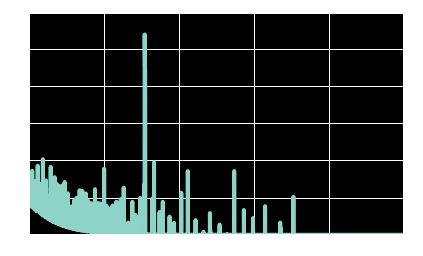

In [230]:
import matplotlib.pyplot as plt
plt.style.use([u'fivethirtyeight', 'dark_background'])
%matplotlib inline
plt.plot(model.history.history['loss'])

In [231]:
pred = model.predict(X[:, :maxlen])

In [232]:
titles = np.argmax(pred, axis=-1)

In [241]:
string_to_array.array_to_string(titles[np.argmax(titles.max(axis=1))], vocab_file='10k')

'acoust weyl node from stack unkown chain'

In [238]:
string_to_array.array_to_string(titles[0], vocab_file='10k')

'exact solut for optim unkown of unkown unkown and the unkown equat'

In [242]:
df.title[np.argmax(titles.max(axis=1))]

u'Acoustic Weyl nodes from stacking dimerized chains'

In [237]:
titles[0]

array([611,  91,  11, 115,   1,   3,   1,   1,   5,   2,   1,  81,   0,
         0,   0,   0])